In [29]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

import numpy as np
import pandas as pd
import os
import glob
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.models import vgg16

In [30]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [31]:
class Retinal_Fundus_Dataset(Dataset):
    def __init__(self,root_dir,transform=None):

        self.all_data=[]
        self.transform=transform

        for img_path in tqdm(glob.glob(root_dir+"/*/**")):
            print(img_path)
            class_name=img_path.split("\\")[-2] 
            specific_name=class_name.split(".")[-1] 
            #img_path.split("/")[-2]
            self.all_data.append([img_path,class_name,specific_name])
 
        self.class_map={}
        for index,item in enumerate(os.listdir(root_dir)):
             self.class_map[item]=index
        print(f"Total Classes:{len(self.class_map)}")
                
    def __len__(self):
        return len(self.all_data)

    def __getitem__(self,idx):
        img_path,class_name,specific_name=self.all_data[idx]
        img=Image.open(img_path)
        class_id=self.class_map[class_name]
        class_id=torch.tensor(class_id)

        if self.transform:
            img=self.transform(img)

        return img,class_id,specific_name

In [33]:
def Retinal_Fundus_Transforms(normalize=False,mean=[0,0,0],std=[1,1,1]):
    if normalize:
        new_transforms=transforms.Compose([
            transforms.Resize((224,224)),
            #transforms.RandomRotation(degrees=33),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,std=std)
        ])
       
    else:
         new_transforms=transforms.Compose([
            transforms.Resize((512,512)),
             #transforms.RandomRotation(degrees=33),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])
        
        
    return new_transforms


In [34]:
num_classes=39
batch_size=8
num_epochs=5
lr=1e-3
ratio_val=0.2
criterion = nn.CrossEntropyLoss()
root_dir=r'temp_orig'

In [35]:
#os.listdir('temp_orig')
print("All classes:")
print(os.listdir(root_dir))
new_transforms=Retinal_Fundus_Transforms(normalize=False)
final_dataset=Retinal_Fundus_Dataset(root_dir,new_transforms)
print(len(final_dataset))
num_images=len(final_dataset)
num_val=int(num_images*ratio_val)
num_train=num_images-num_val
train_set, val_set=random_split(final_dataset,[num_train,num_val],generator=torch.Generator().manual_seed(7))
train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_set,batch_size=batch_size,shuffle=True)

All classes:
['0.0.Normal', '0.1.Tessellated fundus', '0.2.Large optic cup', '0.3.DR1', '1.0.DR2', '1.1.DR3', '10.0.Possible glaucoma', '10.1.Optic atrophy', '11.Severe hypertensive retinopathy', '12.Disc swelling and elevation', '13.Dragged Disc', '14.Congenital disc abnormality', '15.0.Retinitis pigmentosa', '15.1.Bietti crystalline dystrophy', '16.Peripheral retinal degeneration and break', '17.Myelinated nerve fiber', '18.Vitreous particles', '19.Fundus neoplasm', '2.0.BRVO', '2.1.CRVO', '20.Massive hard exudates', '21.Yellow-white spots-flecks', '22.Cotton-wool spots', '23.Vessel tortuosity', '24.Chorioretinal atrophy-coloboma', '25.Preretinal hemorrhage', '26.Fibrosis', '27.Laser Spots', '28.Silicon oil in eye', '29.0.Blur fundus without PDR', '29.1.Blur fundus with suspected PDR', '3.RAO', '4.Rhegmatogenous RD', '5.0.CSCR', '5.1.VKH disease', '6.Maculopathy', '7.ERM', '8.MH', '9.Pathological myopia']


  0%|          | 0/1000 [00:00<?, ?it/s]

temp_orig\0.0.Normal\1ffa9627-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9628-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9629-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa962a-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa962b-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa962d-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa962e-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa962f-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9630-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9631-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9632-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9633-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9634-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9636-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9638-8d87-11e8-9daf-6045cb817f5b..JPG
temp_orig\0.0.Normal\1ffa9639-8d87-11e8-9daf-6045cb817f

In [36]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum,num_batches=0,0,0
    for data,_ in tqdm(loader):
        channels_sum+=torch.mean(data,dim=[0,2,3]) # we dont want to a singuar mean for al 3 channels (in case of RGB)
        channels_squared_sum+=torch.mean(data**2,dim=[0,2,3])
        print(num_batches)
        num_batches+=1
    mean=channels_sum/num_batches
    std=(channels_squared_sum/num_batches-mean**2)**0.5
    
    return mean, std

In [37]:
#mean,std=get_mean_std(train_loader)

mean= torch.tensor([0.4629, 0.2684, 0.1068])
std= torch.tensor([0.2376, 0.1520, 0.0817])
print(mean, std)

tensor([0.4629, 0.2684, 0.1068]) tensor([0.2376, 0.1520, 0.0817])


In [12]:
# def img_display(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     npimg = np.transpose(npimg, (1, 2, 0))
#     return npimg

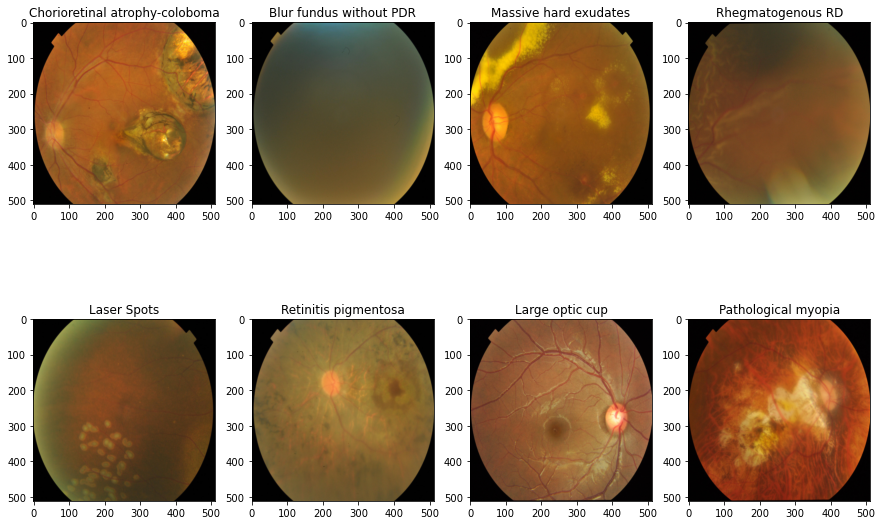

In [13]:
# display some random training images
dataiter = iter(train_loader)
images, labels, specific_classnames = dataiter.next()
fig, axis = plt.subplots(2, int(batch_size/2), figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, specific_classname = images[i], labels[i], specific_classnames[i]
        ax.imshow(image.permute(1, 2, 0)) # add image
        ax.set(title = f"{specific_classname}")

In [38]:
vgg_model=vgg16(pretrained=True)
print(vgg_model)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
for param in vgg_model.parameters():
    param.requires_grad=False
    
    
vgg_model.classifier=nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(),
    nn.Dropout(p=0.37),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024,num_classes)
)

vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
def train_model(model):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9,verbose=True)
    
    loss_stats = {
                    'train': [],
                    "val": []
                }
    # enumerate epochs
    for epoch in tqdm(range(1, num_epochs+1)):
        print(f'Starting epoch {epoch}')# Print epoch
        
        #----training starts---------------------------
        train_epoch_loss = 0
        model.train()
        
        #loop=tqdm(enumerate(train_loader),total=len(train_loader))
        #for batch_idx,(data,targets) in loop:
            
        train_loader_loop=tqdm(enumerate(train_loader),total=len(train_loader))
        #for batch_idx,(data,targets) in loop:
        len_train=0
        for i, (inputs_batch,targets_batch, specific_class_names) in train_loader_loop:  #--enumerate each train batch--------
            inputs, targets = inputs_batch.to(device), targets_batch.to(device)
            optimizer.zero_grad() #clear out the gradients from the last step loss.backward()
            
            #data=data.to(device)
            #targets=targets.to(device)

            #forward
            #scores=model(inputs)
            y_pred=model(inputs)
            loss=criterion(y_pred,targets)
            loss.backward() #backward propagation: calculate gradients
        
            optimizer.step() # update weights
            train_epoch_loss += loss.item()
            len_train+=1
        #----training ends---------------------------   
        
        #----val starts-----------------------------
        len_val=0
        with torch.no_grad():
            val_epoch_loss = 0
            model.eval()
            total = 0
            sum_loss = 0
            correct = 0
            
            val_loader_loop=tqdm(enumerate(val_loader),total=len(val_loader))
            for i, (inputs_val_batch, targets_val_batch, specific_class_names) in val_loader_loop:#--enumerate each val batch--------
                inputs_val, targets_val = inputs_val_batch.to(device), targets_val_batch.to(device)
                
                y_val_pred = model(inputs_val)
                      
                #targets_val = targets_val.long()
                
                val_loss = criterion(y_val_pred, targets_val) 
            
                val_epoch_loss += val_loss.item()
                len_val+=1
        
        #----val ends-------------------------------
        loss_stats['train'].append(train_epoch_loss/len_train)
        loss_stats['val'].append(val_epoch_loss/len_val) 
        print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len_train:.5f} | Val Loss: {val_epoch_loss/len_val:.5f}')
        

    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    plt.figure(figsize=(15,8))
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/5 [00:00<?, ?it/s]

Starting epoch 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3.25068 | Val Loss: 2.78996
Starting epoch 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 002: | Train Loss: 2.55681 | Val Loss: 2.55695
Starting epoch 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 003: | Train Loss: 2.33411 | Val Loss: 2.30944
Starting epoch 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 004: | Train Loss: 2.12354 | Val Loss: 2.10280
Starting epoch 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 005: | Train Loss: 1.98681 | Val Loss: 1.99936


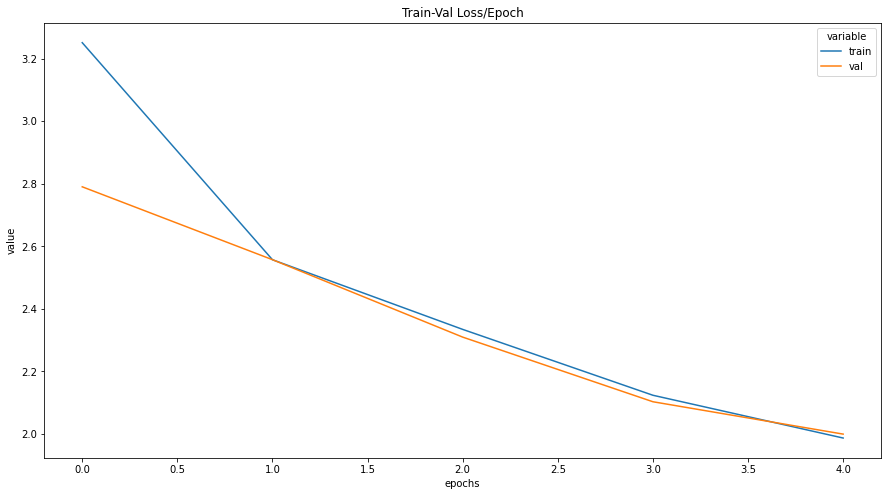

In [17]:
train_model(vgg_model)

In [27]:
def evaluate_model(test_loader, model):
    correct_samples = 0
    total_samples = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets, specific_class_names in tqdm(test_loader):
            inputs, targets = inputs.to(device=device), targets.to(device=device)
            pred = model(inputs)
            _, y_pred = pred.max(1)
            correct_samples += (y_pred == targets).sum()
            total_samples += y_pred.size(0)
        accuracy=correct_samples*100.0/total_samples
        print(f"Accuracy is  {accuracy:.2f} with correct samples {correct_samples} / {total_samples}.")
    model.train()
                
        
    
#         print("Accuracy is {}")
#          print(
#             f"Got {correct_samples} / {total_samples} with accuracy {accuracy:.2f}"
#         )                                              p

    

In [28]:
print("Training accuracy:",end='\t')
evaluate_model(train_loader, vgg_model)
print("Validation accuracy:",end='\t')
evaluate_model(val_loader, vgg_model)

Training accuracy:	

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy is  56.50 with correct samples 452 / 800.
Validation accuracy:	

  0%|          | 0/25 [00:00<?, ?it/s]

Accuracy is  44.50 with correct samples 89 / 200.
